In [1]:
# Parameters
DATA_PATH = "../tests/fixtures/customer_emails.csv"


# Start Here: Data Discovery

**Purpose:** Create a point-in-time snapshot and understand your dataset's structure through automatic profiling.

**What you'll learn:**
- How to create temporally-safe training snapshots
- How automatic type inference works and when to override it
- How to identify entity-level vs event-level data
- How to set up your target column for downstream analysis

**Outputs:**
- Point-in-time training snapshot (Parquet)
- Dataset overview (rows, columns, memory, format, structure)
- Automatic column type inference with confidence scores
- Saved exploration findings (YAML)

---

## How to Read This Notebook

Each section includes:
- **📊 Charts** - Interactive Plotly visualizations
- **📖 Interpretation Guide** - How to read and understand the output
- **✅ Actions** - What to do based on the findings

## 1.1 Configuration

Configure your data source and target column **before** running the notebook.

In [2]:
from datetime import datetime
from pathlib import Path

import pandas as pd

from customer_retention.analysis.auto_explorer import DataExplorer
from customer_retention.analysis.auto_explorer.findings import TimeSeriesMetadata
from customer_retention.analysis.visualization import ChartBuilder, console, display_figure, display_table
from customer_retention.core.config.column_config import DatasetGranularity
from customer_retention.core.config.experiments import (
    FINDINGS_DIR,  # noqa: F401 - required for test validation
    OUTPUT_DIR,
    setup_experiments_structure,
)
from customer_retention.stages.profiling import TypeDetector
from customer_retention.stages.temporal import (
    TEMPORAL_METADATA_COLS,
    CutoffAnalyzer,
    PointInTimeRegistry,
    ScenarioDetector,
    UnifiedDataPreparer,
)
from customer_retention.stages.validation import TimeSeriesDetector

In [3]:
# =============================================================================
# CONFIGURATION - Set these before running
# =============================================================================

# DATA_PATH: Path to your data file (CSV, Parquet, or Delta)
DATA_PATH = "../tests/fixtures/customer_retention_retail.csv"

# TARGET_COLUMN: Your prediction target (set to None for auto-detection)
TARGET_COLUMN = "unsubscribed"

# ENTITY_COLUMN: Customer/user ID column (set to None for auto-detection)
ENTITY_COLUMN = None

# LABEL_WINDOW_DAYS: Days after last activity to derive label timestamp
# Used when no explicit label timestamp column exists (e.g., churn_date)
# Default: 180 days (6 months observation window)
LABEL_WINDOW_DAYS = 180

# TIMESTAMP_CONFIG: Override auto-detection if needed (set to None for auto-detection)
# Example manual override:
# TIMESTAMP_CONFIG = TimestampConfig(
#     strategy=TimestampStrategy.PRODUCTION,
#     feature_timestamp_column="observation_date",
#     label_timestamp_column="churn_date",
# )
TIMESTAMP_CONFIG = None

# =============================================================================
# SAMPLE DATASETS (for learning/testing only)
# =============================================================================
# ENTITY-LEVEL (one row per customer):
# DATA_PATH = "../tests/fixtures/customer_retention_retail.csv"
# DATA_PATH = "../tests/fixtures/bank_customer_churn.csv"
# DATA_PATH = "../tests/fixtures/netflix_customer_churn.csv"
#
# EVENT-LEVEL (multiple rows per customer):
# DATA_PATH = "../tests/fixtures/customer_transactions.csv"
DATA_PATH = "../tests/fixtures/customer_emails.csv"
# =============================================================================

# OUTPUT_DIR: All outputs go here (gitignored)
# OUTPUT_DIR imported from customer_retention.core.config.experiments
setup_experiments_structure()  # Creates all experiment directories


## 1.2 Load Data & Create Point-in-Time Snapshot

**This is the critical first step.** We:
1. Load raw data
2. Detect temporal scenario (production timestamps, derived, or synthetic)
3. Create a versioned snapshot with `feature_timestamp` and `label_timestamp`
4. All subsequent analysis uses the snapshot data

This ensures temporal integrity and prevents data leakage.

In [4]:
# Load raw data
raw_df = pd.read_csv(DATA_PATH) if DATA_PATH.endswith('.csv') else pd.read_parquet(DATA_PATH)

console.start_section()
console.header("Raw Data Loaded")
console.metric("Source", DATA_PATH)
console.metric("Rows", f"{len(raw_df):,}")
console.metric("Columns", len(raw_df.columns))
console.end_section()

# Detect granularity and entity column
type_detector = TypeDetector()
granularity_result = type_detector.detect_granularity(raw_df)
entity_column = ENTITY_COLUMN or granularity_result.entity_column

# Detect or use provided timestamp configuration
if TIMESTAMP_CONFIG:
    ts_config = TIMESTAMP_CONFIG
    scenario = "MANUAL_OVERRIDE"
    discovery_result = None
    console.info(f"Using manual timestamp config: {ts_config.strategy.value}")
else:
    detector = ScenarioDetector(label_window_days=LABEL_WINDOW_DAYS)
    scenario, ts_config, discovery_result = detector.detect(raw_df, TARGET_COLUMN)

console.start_section()
console.header("Temporal Scenario Detection")
console.metric("Scenario", scenario)
console.metric("Strategy", ts_config.strategy.value)
console.metric("Label Window", f"{LABEL_WINDOW_DAYS} days")

if discovery_result:
    if discovery_result.feature_timestamp:
        source_col = discovery_result.feature_timestamp.column_name
        if discovery_result.feature_timestamp.is_derived:
            console.metric("Feature Timestamp", f"derived from {discovery_result.feature_timestamp.source_columns}")
        else:
            was_promoted = "promoted" in discovery_result.feature_timestamp.notes.lower()
            if was_promoted:
                console.metric("Feature Timestamp", f"{source_col} (auto-selected as latest activity)")
            else:
                console.metric("Feature Timestamp", f"{source_col} (explicit match)")

    if discovery_result.label_timestamp:
        if discovery_result.label_timestamp.is_derived:
            console.metric("Label Timestamp", f"derived: {discovery_result.label_timestamp.derivation_formula}")
        else:
            console.metric("Label Timestamp", f"{discovery_result.label_timestamp.column_name} (explicit match)")

    if "datetime_ordering" in discovery_result.discovery_report:
        ordering = discovery_result.discovery_report["datetime_ordering"]
        if ordering:
            console.info(f"Datetime column ordering: {' → '.join(ordering)}")

console.end_section()

#### RAW DATA LOADED  
Source: **../tests/fixtures/customer_emails.csv**  
Rows: **83,198**  
Columns: **13**

#### TEMPORAL SCENARIO DETECTION  
Scenario: **production**  
Strategy: **production**  
Label Window: **180 days**  
Feature Timestamp: **sent_date (auto-selected as latest activity)**  
Label Timestamp: **unsubscribe_date (explicit match)**  
*(i) Datetime column ordering: sent_date → unsubscribe_date*

### Cutoff Date Selection

The chart below shows the temporal distribution of your data. Use it to select an appropriate cutoff date:

- **Top chart**: Records per time bin and cumulative count
- **Bottom chart**: Train/Score split percentage at each potential cutoff date
- **Suggested cutoff** (blue dashed): Achieves ~90% train / 10% score split

**Final data allocation:**
- Cutoff: 90% train, 10% score (holdout for final evaluation)
- Train/Test split: 89% train, 11% test (from the 90%)
- **Result: ~80% training, ~10% test, ~10% score**

Adjust `CUTOFF_DATE` below if the suggested date doesn't fit your needs.

In [5]:
# Analyze temporal distribution for cutoff selection
from customer_retention.stages.temporal import DatetimeOrderAnalyzer

cutoff_analyzer = CutoffAnalyzer()
cutoff_analysis = None

# Derive last_action_date by coalescing all datetime columns (latest-median first)
datetime_order_analyzer = DatetimeOrderAnalyzer()
last_action_series = datetime_order_analyzer.derive_last_action_date(raw_df)

# Fallback to feature_timestamp column if no datetime columns found
timestamp_col = None
if last_action_series is None:
    if discovery_result and discovery_result.feature_timestamp:
        if not discovery_result.feature_timestamp.is_derived:
            timestamp_col = discovery_result.feature_timestamp.column_name

# Check registry for existing cutoff
pit_registry = PointInTimeRegistry(OUTPUT_DIR)
registry_cutoff = pit_registry.check_consistency().reference_cutoff

if last_action_series is not None:
    cutoff_analysis = cutoff_analyzer.analyze(raw_df, timestamp_series=last_action_series, n_bins=50)
    data_suggested_cutoff = cutoff_analysis.suggest_cutoff(train_ratio=0.9)

    console.start_section()
    console.header("Cutoff Date Analysis")
    console.metric("Timestamp Source", "last_action_date (coalesced)")
    console.metric("Coverage", f"{cutoff_analysis.covered_rows:,} / {cutoff_analysis.source_rows:,} rows ({cutoff_analysis.coverage_ratio:.1%})")
    if cutoff_analysis.coverage_ratio < 0.95:
        console.warning("Low timestamp coverage — consider filling missing dates")
    console.metric("Date Range", f"{cutoff_analysis.date_range[0].strftime('%Y-%m-%d')} to {cutoff_analysis.date_range[1].strftime('%Y-%m-%d')}")
    console.metric("Data-Suggested Cutoff", data_suggested_cutoff.strftime("%Y-%m-%d"))
    split = cutoff_analysis.get_split_at_date(data_suggested_cutoff)
    console.metric("At Suggested Split", f"{split['train_pct']:.0f}% train / {split['score_pct']:.0f}% score")

    if registry_cutoff:
        console.warning(f"Registry has cutoff: {registry_cutoff.date()} (may be stale)")
        console.info("To clear: pit_registry.clear_registry()")

    # Show milestones for reference
    milestones = cutoff_analysis.get_percentage_milestones(step=10)
    if milestones:
        console.subheader("Reference Dates (10% intervals)")
        for m in milestones:
            console.info(f"  {m['train_pct']:.0f}% train: {m['date'].strftime('%Y-%m-%d')}")
    console.end_section()
elif timestamp_col:
    cutoff_analysis = cutoff_analyzer.analyze(raw_df, timestamp_column=timestamp_col, n_bins=50)
    data_suggested_cutoff = cutoff_analysis.suggest_cutoff(train_ratio=0.9)

    console.start_section()
    console.header("Cutoff Date Analysis")
    console.metric("Timestamp Column", timestamp_col)
    console.metric("Coverage", f"{cutoff_analysis.covered_rows:,} / {cutoff_analysis.source_rows:,} rows ({cutoff_analysis.coverage_ratio:.1%})")
    if cutoff_analysis.coverage_ratio < 0.95:
        console.warning("Low timestamp coverage — consider filling missing dates")
    console.metric("Date Range", f"{cutoff_analysis.date_range[0].strftime('%Y-%m-%d')} to {cutoff_analysis.date_range[1].strftime('%Y-%m-%d')}")
    console.metric("Data-Suggested Cutoff", data_suggested_cutoff.strftime("%Y-%m-%d"))
    split = cutoff_analysis.get_split_at_date(data_suggested_cutoff)
    console.metric("At Suggested Split", f"{split['train_pct']:.0f}% train / {split['score_pct']:.0f}% score")

    if registry_cutoff:
        console.warning(f"Registry has cutoff: {registry_cutoff.date()} (may be stale)")
        console.info("To clear: pit_registry.clear_registry()")

    milestones = cutoff_analysis.get_percentage_milestones(step=10)
    if milestones:
        console.subheader("Reference Dates (10% intervals)")
        for m in milestones:
            console.info(f"  {m['train_pct']:.0f}% train: {m['date'].strftime('%Y-%m-%d')}")
    console.end_section()
else:
    data_suggested_cutoff = datetime.now()
    console.start_section()
    console.header("Cutoff Date Analysis")
    console.warning("No timestamp column detected")
    console.metric("Default Cutoff", data_suggested_cutoff.strftime("%Y-%m-%d"))
    if registry_cutoff:
        console.info(f"Registry cutoff: {registry_cutoff.date()}")
    console.end_section()

#### CUTOFF DATE ANALYSIS  
Timestamp Source: **last_action_date (coalesced)**  
Coverage: **83,198 / 83,198 rows (100.0%)**  
Date Range: **2015-01-01 to 2023-12-30**  
Data-Suggested Cutoff: **2022-09-26**  
At Suggested Split: **90% train / 10% score**  
[!] Registry has cutoff: 2022-09-26 (may be stale)  
*(i) To clear: pit_registry.clear_registry()*  
**Reference Dates (10% intervals)**  
*(i)   12% train: 2015-07-17*  
*(i)   22% train: 2016-04-04*  
*(i)   32% train: 2016-12-23*  
*(i)   41% train: 2017-09-12*  
*(i)   51% train: 2018-08-07*  
*(i)   61% train: 2019-07-01*  
*(i)   72% train: 2020-07-29*  
*(i)   80% train: 2021-06-23*  
*(i)   91% train: 2022-09-26*

#### SELECTED CUTOFF DATE  
*(i) Using data-suggested: 2022-09-26*  
Train/Score Split: **90% / 10%**  
Train Records: **74,842**  
Score Records: **8,356**

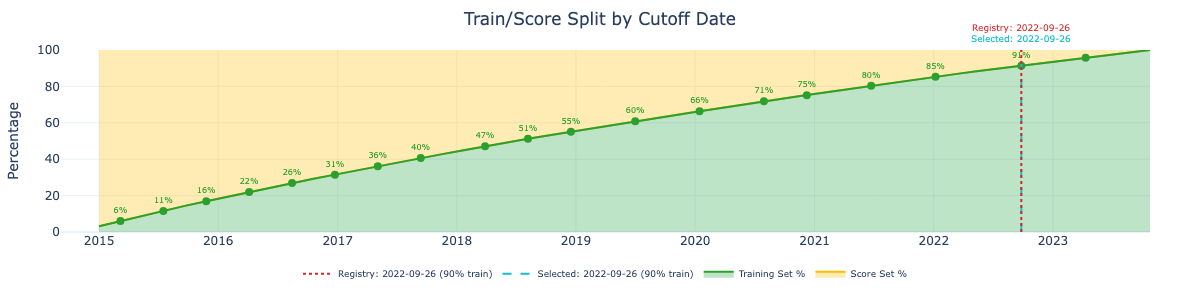

In [6]:
# =============================================================================
# CUTOFF DATE SELECTION - Set your preferred cutoff date
# =============================================================================
# Options:
#   None = use data-suggested cutoff (~90/10 split)
#   datetime(YYYY, M, D) = use specific date
#
# To clear stale registry: pit_registry.clear_registry()
# =============================================================================
CUTOFF_DATE = None  # e.g., datetime(2017, 7, 1)

# Compute final selected cutoff
selected_cutoff = CUTOFF_DATE or data_suggested_cutoff

console.start_section()
console.header("Selected Cutoff Date")
if CUTOFF_DATE:
    console.info(f"Manual override: {CUTOFF_DATE.strftime('%Y-%m-%d')}")
else:
    console.info(f"Using data-suggested: {selected_cutoff.strftime('%Y-%m-%d')}")

if cutoff_analysis:
    split = cutoff_analysis.get_split_at_date(selected_cutoff)
    console.metric("Train/Score Split", f"{split['train_pct']:.0f}% / {split['score_pct']:.0f}%")
    console.metric("Train Records", f"{split['train_count']:,}")
    console.metric("Score Records", f"{split['score_count']:,}")
console.end_section()

# Display chart with selected cutoff
if cutoff_analysis:
    chart_builder = ChartBuilder()
    display_figure(chart_builder.cutoff_selection_chart(
        cutoff_analysis,
        suggested_cutoff=selected_cutoff,
        current_cutoff=registry_cutoff
    ))

In [7]:
# pit_registry already initialized in cutoff analysis cell
dataset_name = Path(DATA_PATH).stem

# Use the user's selected cutoff (not forced by registry)
cutoff_date = selected_cutoff

# Warn if overriding registry
if registry_cutoff and registry_cutoff.date() != selected_cutoff.date():
    console.start_section()
    console.header("Registry Update")
    console.warning(f"Overriding registry cutoff ({registry_cutoff.date()}) with {selected_cutoff.date()}")
    console.info("All datasets in this project should use the same cutoff date")
    console.end_section()

preparer = UnifiedDataPreparer(OUTPUT_DIR, ts_config)
df = preparer.prepare_from_raw(raw_df, target_column=TARGET_COLUMN, entity_column=entity_column or "entity_id")

# Use the same last_action_series from cutoff analysis for snapshot splitting
# (do NOT re-derive on prepared df, which has extra timestamp columns)
snapshot_df, snapshot_metadata = preparer.create_training_snapshot(
    df, cutoff_date, timestamp_series=last_action_series
)

pit_registry.register_snapshot(
    dataset_name=dataset_name,
    snapshot_id=snapshot_metadata['snapshot_id'],
    cutoff_date=cutoff_date,
    source_path=DATA_PATH,
    row_count=snapshot_metadata['row_count']
)

console.start_section()
console.header("Point-in-Time Snapshot Created")
console.metric("Dataset", dataset_name)
console.metric("Snapshot ID", snapshot_metadata['snapshot_id'])
console.metric("Rows", f"{snapshot_metadata['row_count']:,}")
console.metric("Features", len(snapshot_metadata['feature_columns']))
console.metric("Cutoff Date", str(cutoff_date.date()))
console.metric("Data Hash", snapshot_metadata['data_hash'][:16] + "...")

# Sanity check: snapshot size should be consistent with cutoff analysis
if cutoff_analysis:
    expected_split = cutoff_analysis.get_split_at_date(cutoff_date)
    expected_train = expected_split['train_count']
    actual_ratio = snapshot_metadata['row_count'] / len(df) * 100
    console.metric("Split Ratio", f"{actual_ratio:.0f}% train / {100 - actual_ratio:.0f}% score")
    if abs(actual_ratio - expected_split['train_pct']) > 10:
        console.error(
            f"SPLIT MISMATCH: snapshot has {snapshot_metadata['row_count']:,} rows "
            f"({actual_ratio:.0f}%) but analysis expected {expected_train:,} ({expected_split['train_pct']:.0f}%)"
        )

if "feature_timestamp" in df.columns:
    console.success("Temporal columns added: feature_timestamp, label_timestamp")
else:
    console.warning("No temporal columns added (synthetic strategy)")

updated_report = pit_registry.check_consistency()
if updated_report.is_consistent:
    console.success(f"All {len(pit_registry.snapshots)} datasets use cutoff: {cutoff_date.date()}")
else:
    console.error("INCONSISTENT CUTOFF DATES DETECTED")
    console.warning(f"Out of sync: {', '.join(updated_report.inconsistent_datasets)}")
    console.info("Re-run notebook 01 for out-of-sync datasets to align cutoff dates")

console.end_section()

df = snapshot_df

#### POINT-IN-TIME SNAPSHOT CREATED  
Dataset: **customer_emails**  
Snapshot ID: **training_v2**  
Rows: **74,842**  
Features: **12**  
Cutoff Date: **2022-09-26**  
Data Hash: **51053360611aa638...**  
Split Ratio: **90% train / 10% score**  
[OK] Temporal columns added: feature_timestamp, label_timestamp  
[OK] All 1 datasets use cutoff: 2022-09-26

## 1.3 Dataset Exploration

Now we explore the **snapshot data** (not raw data). This ensures all visualizations and metrics reflect the actual training data with temporal integrity.

Findings saved to: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_findings.yaml


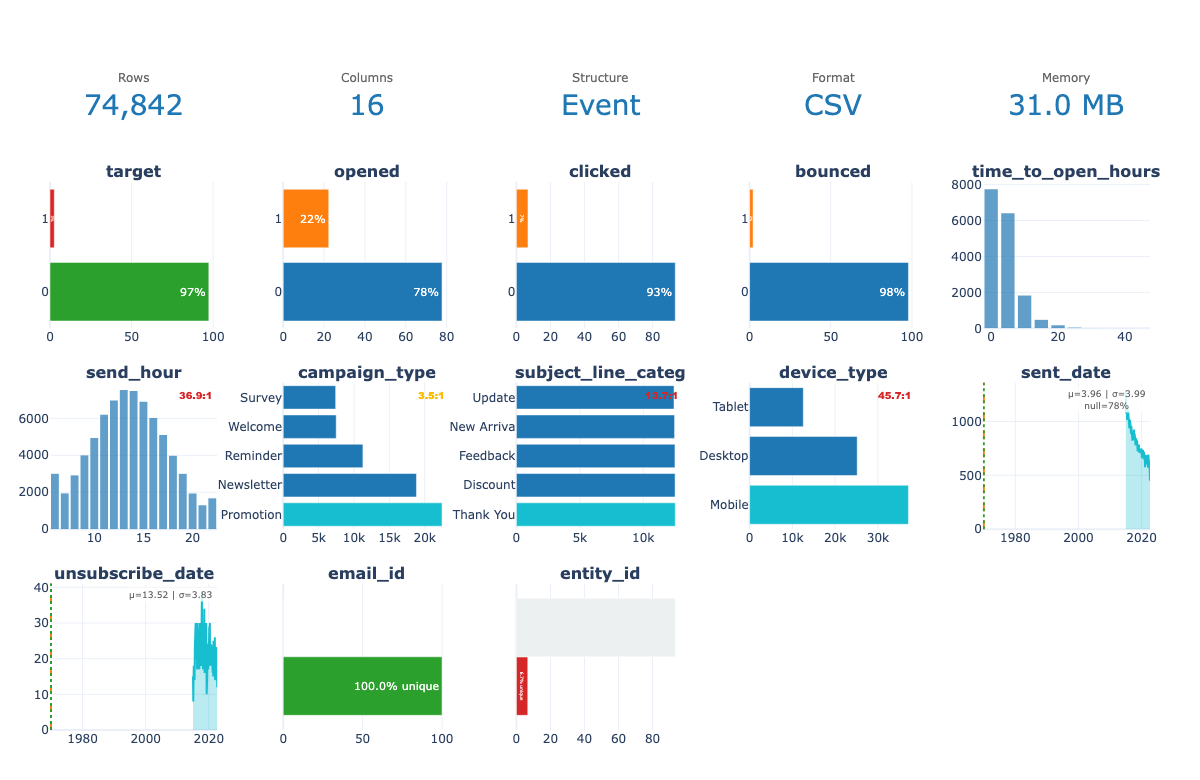

In [8]:
# Explore the snapshot data
# Note: UnifiedDataPreparer renames the target column to "target" in the snapshot
# So we use "target" as the hint, not the original TARGET_COLUMN name
explorer = DataExplorer(visualize=False, save_findings=True, output_dir=str(OUTPUT_DIR))
findings = explorer.explore(df, target_hint="target", name=dataset_name)
findings.source_path = DATA_PATH

# Store snapshot info in findings
findings.snapshot_id = snapshot_metadata['snapshot_id']
findings.snapshot_path = str(OUTPUT_DIR / "snapshots" / f"{snapshot_metadata['snapshot_id']}.parquet")
findings.timestamp_scenario = scenario
findings.timestamp_strategy = ts_config.strategy.value

# Also store the original target column name for reference
findings.metadata["original_target_column"] = TARGET_COLUMN

granularity = "event" if granularity_result.granularity == DatasetGranularity.EVENT_LEVEL else "entity"

# Display dataset overview
chart_builder = ChartBuilder()
display_figure(chart_builder.dataset_at_a_glance(
    df, findings,
    source_path=f"Snapshot: {snapshot_metadata['snapshot_id']}",
    granularity=granularity,
    max_columns=15,
    columns_per_row=5
))

## 1.4 Column Summary Table

In [9]:
# Exclude temporal metadata columns from summary

summary_data = []
for name, col in findings.columns.items():
    if name in TEMPORAL_METADATA_COLS:
        continue
    null_pct = col.universal_metrics.get("null_percentage", 0)
    distinct = col.universal_metrics.get("distinct_count", "N/A")
    summary_data.append({
        "Column": name,
        "Type": col.inferred_type.value,
        "Confidence": f"{col.confidence:.0%}",
        "Nulls %": f"{null_pct:.1f}%",
        "Distinct": distinct,
        "Evidence": col.evidence[0] if col.evidence else ""
    })

summary_df = pd.DataFrame(summary_data)
display_table(summary_df)

Column,Type,Confidence,Nulls %,Distinct,Evidence
email_id,identifier,90%,0.0%,74842,Column name contains identifier pattern
entity_id,identifier,90%,0.0%,4998,Column name contains identifier pattern
sent_date,datetime,90%,0.0%,2826,100/100 values parseable as datetime
campaign_type,categorical_nominal,90%,0.0%,6,String with 6 unique values (≤10)
opened,binary,90%,0.0%,2,"Exactly 2 unique values: {np.int64(0), np.int64(1)}"
clicked,binary,90%,0.0%,2,"Exactly 2 unique values: {np.int64(0), np.int64(1)}"
subject_line_category,categorical_nominal,90%,0.0%,6,String with 6 unique values (≤10)
send_hour,numeric_discrete,70%,0.0%,17,Numeric with 17 unique values (≤20)
device_type,categorical_nominal,90%,0.0%,3,String with 3 unique values (≤10)
target,target,90%,0.0%,2,Column name contains generic target pattern 'target' with 2 classes


## 1.5 Target Column Verification

In [10]:
console.start_section()
console.header("Target Column")

if findings.target_column and findings.target_column in df.columns:
    console.success(f"Target: {findings.target_column}")
    target_counts = df[findings.target_column].value_counts()
    for val, count in target_counts.items():
        pct = (count / len(df)) * 100
        console.metric(f"Class {val}", f"{count:,} ({pct:.1f}%)")
    if granularity_result.granularity == DatasetGranularity.EVENT_LEVEL:
        console.info("Note: Event-level distribution (per row, not per entity)")
else:
    console.warning("No target column configured")
    console.info("Set TARGET_COLUMN in the configuration cell above")

console.end_section()

#### TARGET COLUMN  
[OK] Target: target  
Class 0: **72,869 (97.4%)**  
Class 1: **1,973 (2.6%)**  
*(i) Note: Event-level distribution (per row, not per entity)*

## 1.6 Dataset Structure Detection

In [11]:
ts_detector = TimeSeriesDetector()
valid_entity_col = entity_column if entity_column and entity_column in df.columns else None
if not valid_entity_col:
    for col in df.columns:
        if any(p in col.lower() for p in ["customer", "user", "entity", "account"]) and "id" in col.lower():
            if df[col].nunique() < len(df):
                valid_entity_col = col
                break

detected_ts_col = "feature_timestamp" if "feature_timestamp" in df.columns else None
ts_characteristics = ts_detector.detect(df, entity_column=valid_entity_col, timestamp_column=detected_ts_col)

console.start_section()
console.header("Dataset Structure")
console.metric("Granularity", granularity_result.granularity.value.upper())
if ts_characteristics.dataset_type.value != "unknown":
    console.metric("Temporal Pattern", ts_characteristics.dataset_type.value.upper())
console.metric("Entity Column", valid_entity_col or entity_column or "N/A")

if granularity_result.unique_entities:
    console.metric("Unique Entities", f"{granularity_result.unique_entities:,}")
if granularity_result.avg_events_per_entity:
    console.metric("Avg Events/Entity", f"{granularity_result.avg_events_per_entity:.1f}")

is_event_level = granularity_result.granularity == DatasetGranularity.EVENT_LEVEL
if is_event_level:
    console.info("EVENT-LEVEL DATA - Use Event Bronze Track:")
    console.info("  -> 01a_temporal_deep_dive.ipynb")
    console.info("  -> 01b_temporal_quality.ipynb")
    console.info("  -> 01c_temporal_patterns.ipynb")
    console.info("  -> 01d_event_aggregation.ipynb")
else:
    console.info("ENTITY-LEVEL DATA - Use standard flow:")
    console.info("  -> 02_column_deep_dive.ipynb")
    console.info("  -> 03_quality_assessment.ipynb")

console.end_section()

#### DATASET STRUCTURE  
Granularity: **EVENT_LEVEL**  
Temporal Pattern: **EVENT_LOG**  
Entity Column: **entity_id**  
Unique Entities: **4,998**  
Avg Events/Entity: **16.6**  
*(i) EVENT-LEVEL DATA - Use Event Bronze Track:*  
*(i)   -> 01a_temporal_deep_dive.ipynb*  
*(i)   -> 01b_temporal_quality.ipynb*  
*(i)   -> 01c_temporal_patterns.ipynb*  
*(i)   -> 01d_event_aggregation.ipynb*

## 1.7 Feature Availability Analysis

**Detect tracking changes over time:**
- **New tracking**: Variables that only exist from a certain date (new IT system introduced)
- **Retired tracking**: Variables that stop being tracked (system decommissioned)
- **Partial window**: Variables available only during a specific period

This affects modeling because train/test splits should not cross availability boundaries.

In [12]:
# Feature Availability Analysis - detect tracking changes
from customer_retention.analysis.auto_explorer.findings import FeatureAvailabilityInfo, FeatureAvailabilityMetadata
from customer_retention.stages.profiling import analyze_feature_availability

time_col = detected_ts_col or ts_characteristics.timestamp_column
if time_col and time_col in df.columns:
    exclude_cols = list(TEMPORAL_METADATA_COLS) + ([valid_entity_col] if valid_entity_col else [])
    availability = analyze_feature_availability(df, time_col, exclude_columns=exclude_cols)
    
    console.start_section()
    console.header("Feature Availability")
    console.metric("Data Span", f"{availability.data_start.date()} to {availability.data_end.date()} ({availability.time_span_days} days)")
    
    if availability.new_tracking or availability.retired_tracking or availability.partial_window:
        if availability.new_tracking:
            console.warning(f"New tracking ({len(availability.new_tracking)}): {', '.join(availability.new_tracking[:5])}" + 
                          (f" +{len(availability.new_tracking)-5} more" if len(availability.new_tracking) > 5 else ""))
        if availability.retired_tracking:
            console.warning(f"Retired tracking ({len(availability.retired_tracking)}): {', '.join(availability.retired_tracking[:5])}" +
                          (f" +{len(availability.retired_tracking)-5} more" if len(availability.retired_tracking) > 5 else ""))
        if availability.partial_window:
            console.warning(f"Partial window ({len(availability.partial_window)}): {', '.join(availability.partial_window[:5])}" +
                          (f" +{len(availability.partial_window)-5} more" if len(availability.partial_window) > 5 else ""))
        
        console.subheader("Recommendations")
        for rec in availability.recommendations[:5]:
            if rec["column"] != "_general_":
                console.info(f"{rec['column']}: {rec['reason']}")
        general_recs = [r for r in availability.recommendations if r["column"] == "_general_"]
        if general_recs:
            console.warning("Train/test split should not cross feature availability boundaries")
    else:
        console.success("All features have full temporal coverage")
    console.end_section()
    
    # Store structured availability metadata for downstream use
    features_info = {
        feat.column: FeatureAvailabilityInfo(
            first_valid_date=feat.first_valid_date.isoformat()[:10] if feat.first_valid_date else None,
            last_valid_date=feat.last_valid_date.isoformat()[:10] if feat.last_valid_date else None,
            coverage_pct=feat.coverage_pct,
            availability_type=feat.availability_type,
            days_from_start=feat.days_from_start,
            days_before_end=feat.days_before_end,
        )
        for feat in availability.features
    }
    findings.feature_availability = FeatureAvailabilityMetadata(
        data_start=availability.data_start.isoformat()[:10],
        data_end=availability.data_end.isoformat()[:10],
        time_span_days=availability.time_span_days,
        new_tracking=availability.new_tracking,
        retired_tracking=availability.retired_tracking,
        partial_window=availability.partial_window,
        features=features_info,
    )
else:
    console.info("No timestamp column detected - skipping feature availability analysis")

#### FEATURE AVAILABILITY  
Data Span: **2015-01-01 to 2022-09-26 (2825 days)**  
[OK] All features have full temporal coverage

## 1.8 Type Override (Optional)

Override any incorrectly inferred column types before saving findings.

In [13]:
# === TYPE OVERRIDES ===
TYPE_OVERRIDES = {
    # "column_name": ColumnType.NEW_TYPE,
}

console.start_section()
console.header("Type Override Review")

low_conf = [(name, col.inferred_type.value, col.confidence)
            for name, col in findings.columns.items()
            if col.confidence < 0.8 and name not in TEMPORAL_METADATA_COLS]
if low_conf:
    console.subheader("Low Confidence Detections")
    for col_name, col_type, conf in sorted(low_conf, key=lambda x: x[2]):
        console.warning(f"{col_name}: {col_type} ({conf:.0%})")
else:
    console.success("All type detections have high confidence (>=80%)")

if TYPE_OVERRIDES:
    console.subheader("Applying Overrides")
    for col_name, new_type in TYPE_OVERRIDES.items():
        if col_name in findings.columns:
            old_type = findings.columns[col_name].inferred_type.value
            findings.columns[col_name].inferred_type = new_type
            findings.columns[col_name].confidence = 1.0
            console.success(f"{col_name}: {old_type} -> {new_type.value}")

console.end_section()

#### TYPE OVERRIDE REVIEW  
**Low Confidence Detections**  
[!] send_hour: numeric_discrete (70%)

## 1.9 Save Findings

In [14]:
# Populate time series metadata if event-level
if is_event_level:
    # Use feature_timestamp if available (coalesced column), otherwise fall back to detected column
    snapshot_time_col = "feature_timestamp" if "feature_timestamp" in df.columns else (
        granularity_result.time_column or ts_characteristics.timestamp_column
    )
    findings.time_series_metadata = TimeSeriesMetadata(
        granularity=DatasetGranularity.EVENT_LEVEL,
        temporal_pattern=ts_characteristics.dataset_type.value,
        entity_column=entity_column,
        time_column=snapshot_time_col,
        avg_events_per_entity=granularity_result.avg_events_per_entity,
        time_span_days=int(ts_characteristics.time_span_days) if ts_characteristics.time_span_days else None,
        unique_entities=granularity_result.unique_entities,
        suggested_aggregations=["24h", "7d", "30d", "90d", "all_time"]
    )

FINDINGS_PATH = explorer.last_findings_path
findings.save(FINDINGS_PATH)

console.start_section()
console.header("Findings Saved")
console.success(f"Findings: {FINDINGS_PATH}")
console.success(f"Snapshot: {findings.snapshot_path}")
console.metric("Columns", findings.column_count)
console.metric("Target", findings.target_column or "Not set")
console.metric("Snapshot ID", findings.snapshot_id)
console.metric("Timestamp Strategy", findings.timestamp_strategy)
console.end_section()

#### FINDINGS SAVED  
[OK] Findings: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_findings.yaml  
[OK] Snapshot: /Users/Vital/python/CustomerRetention/experiments/findings/snapshots/training_v2.parquet  
Columns: **16**  
Target: **target**  
Snapshot ID: **training_v2**  
Timestamp Strategy: **production**

## 1.10 Summary

**What was created:**
- Point-in-time snapshot with `feature_timestamp` and `label_timestamp`
- Exploration findings with column types and metrics

**All downstream notebooks load the snapshot**, ensuring:
- Temporal integrity (no data leakage)
- Reproducibility (SHA256 hash verification)
- Consistency (same data across all analysis)

**Next steps:**
- Entity-level data: `02_column_deep_dive.ipynb`
- Event-level data: `01a_temporal_deep_dive.ipynb`